2. 
Explain how you can implement ML in a real world application.

Train an SVM regressor on : Bengaluru housing dataset

                  Must include in details:

                           - EDA

                            - Feature engineering 



In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV


In [38]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.duplicated().sum()

529

In [6]:
df = df.drop_duplicates()
df.shape

(12791, 9)

In [7]:
df.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5328
total_sqft         0
bath              73
balcony          605
price              0
dtype: int64

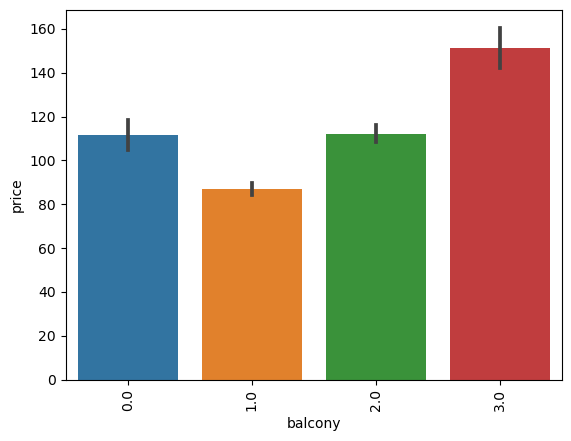

In [8]:
sns.barplot(x=df['balcony'], y=df['price'])
plt.xticks(rotation='vertical')
plt.show()

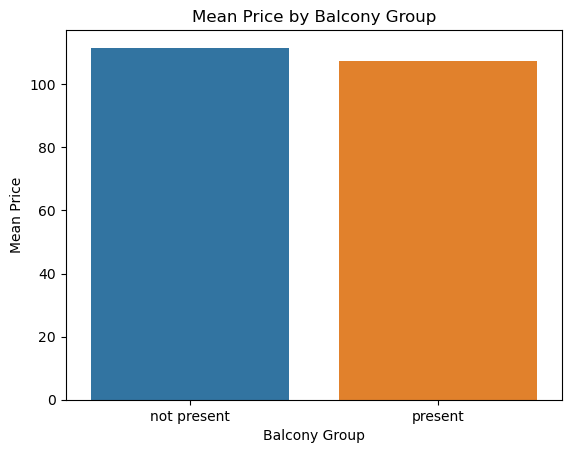

In [9]:
df['grouped_balcony'] = df['balcony'].apply(lambda x: 'present' if x in [1.0, 2.0, 3.0] else 'not present' if x==0.0 else None)
grouped_df = df.groupby('grouped_balcony')['price'].mean().reset_index()

# Plotting the bar plot
sns.barplot(x=grouped_df['grouped_balcony'], y=grouped_df['price'])
plt.xlabel('Balcony Group')
plt.ylabel('Mean Price')
plt.title('Mean Price by Balcony Group')
plt.show()


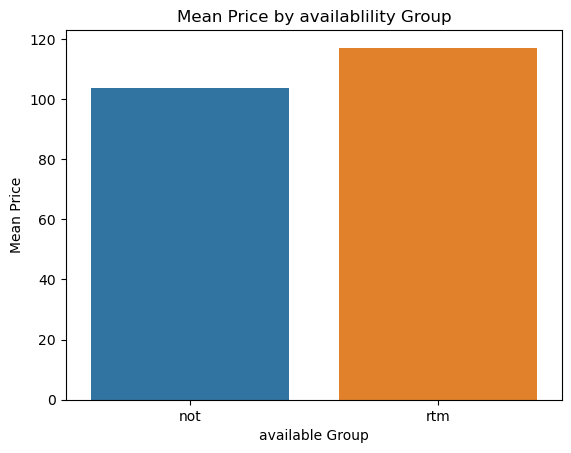

In [10]:
df['grouped_available'] = df['availability'].apply(lambda x: 'rtm' if x=='Ready To Move' else 'not')
grouped_df = df.groupby('grouped_available')['price'].mean().reset_index()

# Plotting the bar plot
sns.barplot(x=grouped_df['grouped_available'], y=grouped_df['price'])
plt.xlabel('available Group')
plt.ylabel('Mean Price')
plt.title('Mean Price by availablility Group')
plt.show()

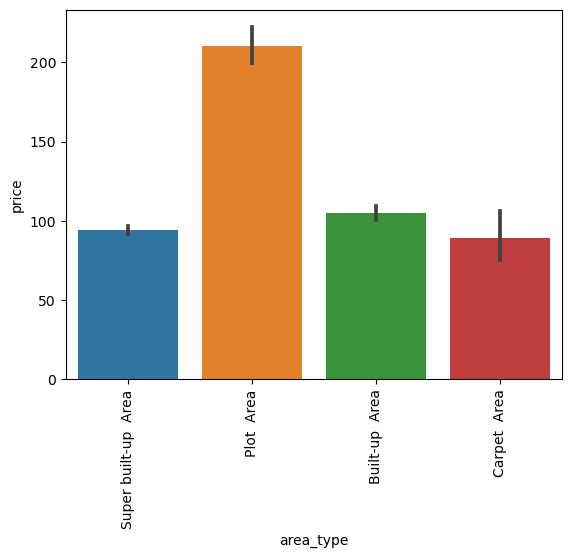

In [11]:
sns.barplot(x=df['area_type'], y=df['price'])
plt.xticks(rotation='vertical')
plt.show()

In [12]:
df.drop(columns = ['balcony','society', 'grouped_balcony', 'grouped_available'], axis=1, inplace=True)

In [13]:
df.describe()

,bath,price
count,12718.000000,12791.000000
mean,2.708602,114.317646
std,1.357764,151.480310
min,1.000000,8.000000
25%,2.000000,50.000000
50%,2.000000,73.000000
75%,3.000000,121.000000
max,40.000000,3600.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12791 entries, 0 to 13318
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     12791 non-null  object 
 1   availability  12791 non-null  object 
 2   location      12790 non-null  object 
 3   size          12775 non-null  object 
 4   total_sqft    12791 non-null  object 
 5   bath          12718 non-null  float64
 6   price         12791 non-null  float64
dtypes: float64(2), object(5)
memory usage: 799.4+ KB


In [15]:
df['location'] = df['location'].fillna('Sarjapur  Road')
df['size'] = df['size'].fillna('2 BHK')
df['bath']= df['bath'].fillna(df['bath'].median())
df['bhk'] = df['size'].str.split(" ").str[0].astype(int)

In [16]:
def check_str(val):
    try:
        float(val) 
    except:
        return True
    return False    

df[df['total_sqft'].apply(check_str)]

,area_type,availability,location,size,total_sqft,bath,price,bhk
30,Super built-up Area,19-Dec,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Built-up Area,20-Feb,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Built-up Area,18-Oct,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Super built-up Area,18-Mar,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,Super built-up Area,19-Mar,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
...,...,...,...,...,...,...,...,...
12975,Super built-up Area,20-Aug,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Super built-up Area,18-May,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Super built-up Area,Ready To Move,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13240,Super built-up Area,Ready To Move,Devanahalli,1 BHK,1020 - 1130,2.0,52.570,1


In [17]:
def convert_range(x):
    temp = x.split('-')
    if len(temp)==2:
        return (float(temp[0])+float(temp[1]))/2
    try:
        return float(x)
    except:
        return None
        
df['total_sqft'] = df['total_sqft'].apply(convert_range)

In [18]:
df = df.dropna()

In [19]:
df.isna().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
price           0
bhk             0
dtype: int64

In [20]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']

In [21]:
df.location = df.location.apply(lambda x : x.strip())
loc_val = df['location'].value_counts()
loc_val

Whitefield                        522
Sarjapur  Road                    380
Electronic City                   289
Kanakpura Road                    247
Thanisandra                       231
                                 ... 
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Kannur                              1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1288, dtype: int64

In [22]:
to_be_others = loc_val[loc_val.values<=10].index

In [23]:
df['location'] = df['location'].apply(lambda x: 'others' if x in to_be_others else x)

df['location'].value_counts()

others              2924
Whitefield           522
Sarjapur  Road       380
Electronic City      289
Kanakpura Road       247
                    ... 
Doddaballapur         11
LB Shastri Nagar      11
Tindlu                11
HAL 2nd Stage         11
Banjara Layout        11
Name: location, Length: 233, dtype: int64

In [24]:
df = df[df['total_sqft']/df['bhk']>=300]
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12011.000000,12011.000000,12011.000000,12011.000000,12011.000000
mean,1606.223870,2.571643,113.252382,2.660644,6363.396694
std,1283.874933,1.090077,154.815223,0.988055,4226.681217
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1117.000000,2.000000,49.975000,2.000000,4250.000000
50%,1306.000000,2.000000,70.000000,3.000000,5330.490405
75%,1715.000000,3.000000,120.000000,3.000000,6967.569041
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


In [25]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, val in df.groupby('location'):
        m = np.mean(val.price_per_sqft)
        std = np.std(val.price_per_sqft)

        gen_df = val[(val.price_per_sqft>=std-m) & (val.price_per_sqft<=std+m)]
        df_out = pd.concat([df_out,gen_df], ignore_index=True)

    return df_out

df = remove_pps_outliers(df)
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,10665.000000,10665.000000,10665.000000,10665.000000,10665.000000
mean,1536.625724,2.476981,90.165037,2.580684,5568.990001
std,1239.533013,1.001621,85.894598,0.923703,2285.591819
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1101.000000,2.000000,48.000000,2.000000,4121.750159
50%,1285.000000,2.000000,65.940000,2.000000,5084.745763
75%,1650.000000,3.000000,100.000000,3.000000,6370.370370
max,52272.000000,16.000000,2200.000000,16.000000,24509.803922


In [26]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

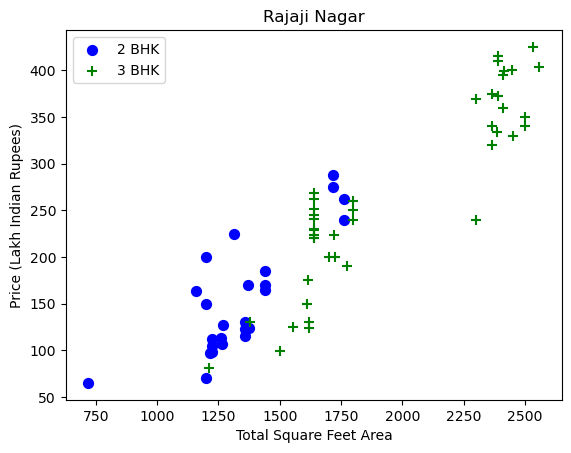

In [27]:
plot_scatter_chart(df,"Rajaji Nagar")

In [28]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df = remove_bhk_outliers(df)
df.shape

(7736, 9)

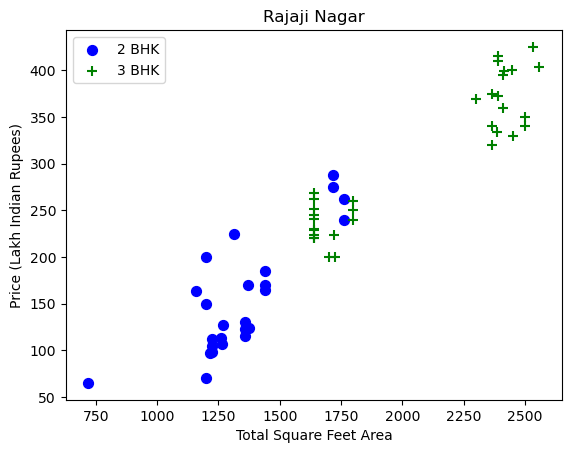

In [29]:
plot_scatter_chart(df,"Rajaji Nagar")

In [30]:
df.drop(['size', 'price_per_sqft'], axis=1, inplace= True)

In [31]:
df['availability'] = df['availability'].apply(lambda x: 1 if x=='Ready To Move' else 0)

In [32]:
df = df[df.bath<df.bhk+2]

In [33]:
df.head()

,area_type,availability,location,total_sqft,bath,price,bhk
0,Super built-up Area,0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,Super built-up Area,0,1st Block Jayanagar,1630.0,3.0,194.0,3
2,Super built-up Area,1,1st Block Jayanagar,1875.0,2.0,235.0,3
3,Super built-up Area,1,1st Block Jayanagar,1000.0,3.0,60.0,2
4,Built-up Area,0,1st Block Jayanagar,1200.0,2.0,130.0,3


<Axes: >

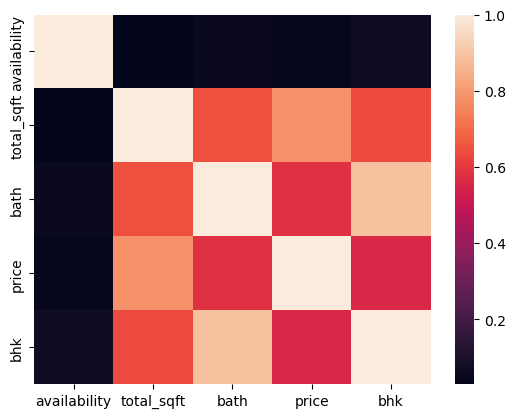

In [34]:
df.corr(numeric_only=True)['price']
sns.heatmap(df.corr(numeric_only=True))

In [35]:
X = df.drop(columns = ['price'])
y = df['price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [39]:
step1 = ColumnTransformer(transformers=[
                         ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'),[0,2])
                 ], remainder='passthrough')
step2 = StandardScaler() 
step3 = SVR()

pipe = Pipeline([
    ('step1', step1),
    ('step2', step2),
    ('step3', step3)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("R2 score ", r2_score(y_test, y_pred))
print("MAE score ", mean_absolute_error(y_test, y_pred))

R2 score  0.31486826625338016
MAE score  31.353958981535914
